<a href="https://colab.research.google.com/github/freyakgray/MedicalTranscriptionClassification/blob/main/roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Transcriptions Categorization
Freya Gray
CS39AA - Natural Language Processing
<br>
This project uses medical transcripts to try and classify the medical specialty that the transcript originated from. The dataset is from the Medical Transcriptions dataset on [Kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions). 
This notebook will implement a pre-trainedmodel, RoBERTa for the classification problem

In [1]:
!pip install transformers

## Imports

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sn


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Dataset


### Drop null entries

In [4]:
url = 'https://github.com/freyakgray/MedicalTranscriptionClassification/blob/main/mtsamples.csv?raw=true'
df = pd.read_csv(url)
df.drop(['Unnamed: 0','description','sample_name'], axis = 1, inplace = True)
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df.describe()

,medical_specialty,transcription,keywords
count,3898,3898,3898
unique,39,1860,3816
top,Surgery,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",
freq,1021,5,81


### Remove medical specialties that have less than 50 entries

In [5]:
value_counts = df.medical_specialty.value_counts()
remove = value_counts[value_counts <= 50].index
df = df[~df.medical_specialty.isin(remove)]
df = df.reset_index(drop=True)

In [6]:
df.describe()

,medical_specialty,transcription,keywords
count,3514,3514,3514
unique,18,1836,3444
top,Surgery,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...",
freq,1021,5,69


In [7]:
df.medical_specialty.value_counts()

 Surgery                          1021
 Orthopedic                        303
 Cardiovascular / Pulmonary        280
 Radiology                         251
 Consult - History and Phy.        234
 Gastroenterology                  195
 Neurology                         168
 General Medicine                  146
 SOAP / Chart / Progress Notes     142
 Urology                           140
 Obstetrics / Gynecology           130
 ENT - Otolaryngology               84
 Neurosurgery                       81
 Ophthalmology                      79
 Discharge Summary                  77
 Nephrology                         63
 Hematology - Oncology              62
 Pain Management                    58
Name: medical_specialty, dtype: int64

In [8]:
df.head()

,medical_specialty,transcription,keywords
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler..."


### Label encoding

In [9]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
df['labels'] = Encoder.fit_transform(df['medical_specialty'])

## Train and Test Sets

In [10]:
#X = df.keywords.values
X = df.transcription.values
y = df.labels.values

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val , y_train, y_val = train_test_split(X, y,test_size=0.2)

In [12]:
X_train

array(['SUBJECTIVE:,  The patient is a 7-year-old male who comes in today with a three-day history of emesis and a four-day history of diarrhea.  Apparently, his brother had similar symptoms.  They had eaten some chicken and then ate some more of it the next day, and I could not quite understand what the problem was because there is a little bit of language barrier, although dad was trying very hard to explain to me what had happened.  But any way, after he and his brother got done eating with chicken, they both felt bad and have continued to feel bad.  The patient has had diarrhea five to six times a day for the last four days and then he had emesis pretty frequently three days ago and then has just had a couple of it each day in the last two days.  He has not had any emesis today.  He has urinated this morning.  His parents are both concerned because he had a fever of 103 last night.  Also, he ate half of a hamburger yesterday and he tried drinking some milk and that is when he had a

In [13]:
y_train

array([ 5, 16,  2, ..., 16,  8, 16])

## Model

### Parameters

In [14]:
batch_size = 8
epochs = 6
num_elements = len(df)
num_categories = df.medical_specialty.value_counts().count()

### Tokenize data and Create TensorFlow dataset

In [15]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
train_encodings = tokenizer(list(X_train), truncation = True, padding ='max_length')
val_encodings = tokenizer(list(X_val), truncation = True, padding ='max_length')

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),list(y_train)))

val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(y_val)))

### Set and fit model

In [16]:
model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels = num_categories)

model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = tf.metrics.SparseCategoricalAccuracy()
        )

history = model.fit(train_dataset.shuffle(len(X_train)).batch(batch_size), validation_data = val_dataset.batch(batch_size), epochs = epochs, verbose=1)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
352/352 [==============================] - 737s 2s/step - loss: 2.2401 - sparse_categorical_accuracy: 0.3501 - val_loss: 1.8420 - val_sparse_categorical_accuracy: 0.3841
Epoch 2/6
352/352 [==============================] - 711s 2s/step - loss: 1.6587 - sparse_categorical_accuracy: 0.4052 - val_loss: 1.4915 - val_sparse_categorical_accuracy: 0.4339
Epoch 3/6
352/352 [==============================] - 713s 2s/step - loss: 1.3740 - sparse_categorical_accuracy: 0.4522 - val_loss: 1.4178 - val_sparse_categorical_accuracy: 0.4182
Epoch 4/6
352/352 [==============================] - 711s 2s/step - loss: 1.2334 - sparse_categorical_accuracy: 0.4803 - val_loss: 1.3751 - val_sparse_categorical_accuracy: 0.3898
Epoch 5/6
352/352 [==============================] - 712s 2s/step - loss: 1.1477 - sparse_categorical_accuracy: 0.4934 - val_loss: 1.4145 - val_sparse_categorical_accuracy: 0.3841
Epoch 6/6
352/352 [==============================] - 713s 2s/step - loss: 1.0876 - sparse_categorica

Plot loss

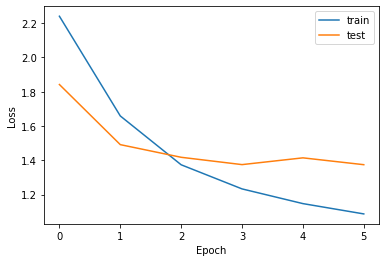

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [18]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 604434    
 ficationHead)                                                   
                                                                 
Total params: 124,659,474
Trainable params: 124,659,474
Non-trainable params: 0
_________________________________________________________________


Predictions from validation set

In [19]:
pred = model.predict(val_dataset.batch(batch_size)).logits
prob=tf.nn.softmax(pred, axis=1).numpy()
predictions=np.argmax(prob, axis=1)

## Confusion Matrix and Metrics

In [20]:
conf_matrix = tf.math.confusion_matrix(y_val,predictions)

In [21]:
conf_labels = [' Cardiovascular / Pulmonary',' Consult - History and Phy.',
              ' Discharge Summary',' ENT - Otolaryngology',
              ' Gastroenterology',' General Medicine',
              ' Hematology - Oncology',' Nephrology', 
              ' Neurology',' Neurosurgery', 
              ' Obstetrics / Gynecology',' Ophthalmology',
              ' Orthopedic',' Pain Management',
              ' Radiology', ' SOAP / Chart / Progress Notes',
              ' Surgery',' Urology']

In [22]:
accuracy = accuracy_score(y_val, predictions)
precision = precision_score(y_val, predictions, average='weighted')
recall = recall_score(y_val, predictions, average='weighted')
f1 = f1_score(y_val, predictions, average='weighted')

<function matplotlib.pyplot.show>

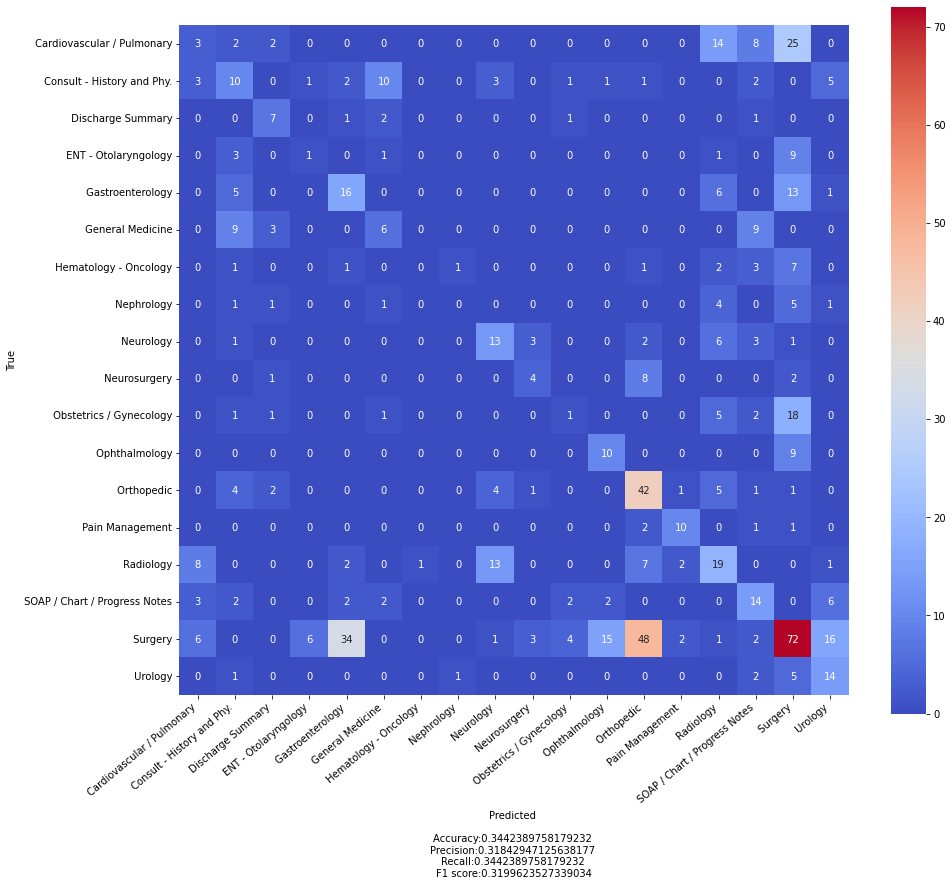

In [23]:
metrics = 'Predicted \n\nAccuracy:{} \nPrecision:{} \nRecall:{} \nF1 score:{}'.format(accuracy, precision, recall, f1)
plt.figure(figsize=(15,13))
matrix = sn.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'coolwarm', square = True, xticklabels = conf_labels, yticklabels = conf_labels) 
matrix.set_xticklabels(matrix.get_xticklabels(), rotation=40, ha="right")
matrix.set(xlabel = metrics, ylabel = 'True')
plt.show

# Sources

**Dataset:**<br/>
[Kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions)

**Guide for Pre-Trained Model:**<br/>
[Hugging Face](https://huggingface.co/docs/transformers/training)